Задача:

Раз уж с кинопоиском все заладилось, тогда и задание будет с ним же.

У кинопоиска есть знаменитый ТОП-250 великих фильмов — https://www.kinopoisk.ru/lists/top250/?sort=popularity&tab=all

Вам нужно перейти по ссылке на каждый фильм и собрать оттуда оценку пользователей Кинопоиска и оценку с IMDB (она сразу под оценкой Кинопоиска серая такая). В итоге у вас должна получиться табличка в формате csv, где будут колонки "film_name", "kipoisk_rate", "imdb_rate".
И потом вы смотрите на разницу между этими оценками, то есть добавляете колонку "diference". А дальше у вас может получиться забавная инфографика про то, какие фильмы больше заходят нам, чем иностранным зрителям, или наоборот.

Решить эту задачу вы можете, как угодно. Можете использовать selenium, чтобы кликать ссылки, а можете просто собрать ссылки в отдельный файл с помощью  BeautifulSoup. А дальше уже открывать этот файл и ходить по ссылкам. Вот вам пример того, как можно собрать ссылки с помощью BeautifulSoup.

In [1]:
from bs4 import BeautifulSoup
import requests
from time import sleep
import pandas as pd
import re

from selenium.webdriver import Chrome
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.common.exceptions import NoSuchElementException

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# функция-дополнение к стандартному пандовому describe

def count_basic_stat(df):
    basic_stat = df.describe()
    
    for i in df:
        try:
            basic_stat.loc['moda',i] = statistics.mode(df[i])
                
        except:
            basic_stat.loc['moda',i] = 'Моды нет'
            
    return basic_stat

In [3]:
driver = Chrome('C:\work\Parsing\chromedriver')

### Парсер ссылок на страницы фильмов: ###

In [4]:
links = [] # список для ссылок на страницы фильмов

In [5]:
for i in range(1, 10): # парсер ссылок на страницы
    url = 'https://www.kinopoisk.ru/lists/top250/?page='+str(i)+'&sort=popularity&tab=all'
    driver.get(url)
    sleep(15)
    
    text = str(driver.page_source) # линки вытаскиваю регуляркой
    need_text = re.findall(r'href=\"\/film\/\d+\/\" class=\"selection-film-item-meta__link', text)
    
    for i in need_text: # чищу мусор
        links += re.findall(r'\/film\/\d+\/', i)

In [6]:
len(links) == 250 # проверка

True

In [7]:
with open('links.txt', 'w', encoding='UTF-8') as new_file: # на всякий случай в файл
    new_links = map(lambda x: x + '\n', links)
    new_file.writelines(new_links)

### Парсер данных со страниц: ###

In [18]:
movies_rat = [] # список для хранения данных о фильмах

In [19]:
for i in links: # парсер
    url = 'https://www.kinopoisk.ru' + i
    driver.get(url)
    sleep(15)
    
    film_name = driver.find_element_by_xpath('/html/body/main/div[4]/div[2]/div[1]/div[1]/div/div[2]/div[1]/div[1]/h1/span').text
    original_name = driver.find_element_by_xpath('/html/body/main/div[4]/div[2]/div[1]/div[1]/div/div[2]/div[1]/div[1]/span').text
    film_director = driver.find_element_by_xpath('/html/body/main/div[4]/div[2]/div[1]/div[1]/div/div[2]/div[3]/div[1]/table/tbody/tr[4]/td[2]/a').text
    kinopoisk_rate = driver.find_element_by_xpath('/html/body/main/div[4]/div[2]/table/tbody/tr/td[1]/div/table/tbody/tr[1]/td/table/tbody/tr[2]/td/form/div[2]/div[1]/div[1]/a/span[1]').text
    imdb_rate = driver.find_element_by_xpath('/html/body/main/div[4]/div[2]/table/tbody/tr/td[1]/div/table/tbody/tr[1]/td/table/tbody/tr[2]/td/form/div[2]/div[1]/div[2]').text
    
    kinopoisk_rate = float(kinopoisk_rate)
    imdb_rate = imdb_rate.split(' ')
    imdb_rate = float(imdb_rate[1])
    
    movies_rat.append([film_name, original_name, film_director, kinopoisk_rate, imdb_rate])

In [20]:
len(movies_rat) == 250

True

In [21]:
len(movies_rat)

250

### Обработка и анализ ###

In [23]:
df = pd.DataFrame(movies_rat) # в датафрейм
df.columns = 'film_name', 'original_name', 'film_director', 'kinopoisk_rate', 'imdb_rate'

In [24]:
df['difference'] = df.kinopoisk_rate - df.imdb_rate

In [25]:
df.to_csv('C:/Users/Boris/Desktop/film_rating.csv', sep=',', encoding='utf-8', index=False) # Запись в csv

In [26]:
# проверка на пустые значения

df.isnull().sum()

film_name         0
original_name     0
film_director     0
kinopoisk_rate    0
imdb_rate         0
difference        0
dtype: int64

In [28]:
count_basic_stat(df.iloc[:,3:])

,kinopoisk_rate,imdb_rate,difference
count,250,250,250
mean,8.23132,8.116,0.115324
std,0.229877,0.412437,0.341075
min,7.807,7,-0.583
25%,8.06275,7.8,-0.14525
50%,8.1685,8.1,0.077
75%,8.3545,8.4,0.34925
max,9.111,9.3,1.227
moda,Моды нет,Моды нет,Моды нет


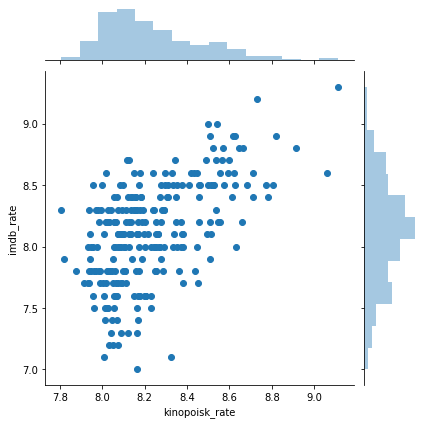

In [29]:
sns.jointplot(x='kinopoisk_rate', y='imdb_rate', data=df, kind='scatter')

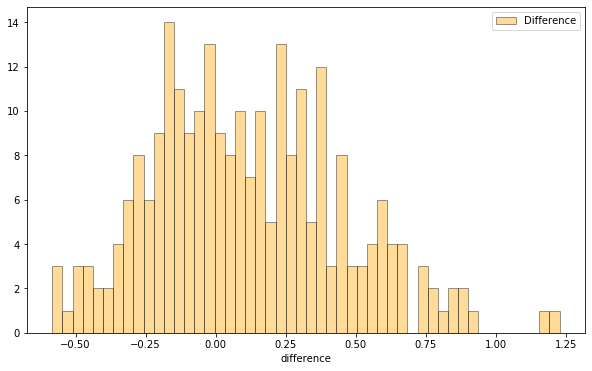

In [32]:
# Гистограмма, чтобы понять разброс

plt.rcParams['figure.figsize']=(10,6)

sns.distplot(df.difference, bins=50, kde=False,
             hist_kws={'color':'orange', 'edgecolor':'k', 'linewidth':'1'},
             kde_kws={'color':'crimson'}

             )

plt.legend(['Difference'])

plt.show()

Видно, что наши зрители чаще ставят более высокие оценки.

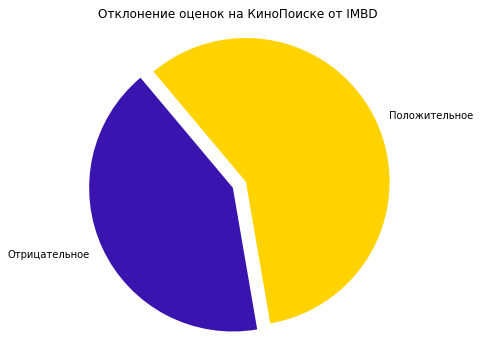

In [34]:
neg_score = len(df.difference[df.difference < 0])
pos_score = len(df.difference[df.difference > 0])

plt.rcParams['figure.figsize']=(6,6)

labels = 'Отрицательное', 'Положительное' 
sizes = [neg_score, pos_score]
explode = (0, 0.1)
colors = ['#3914AF', '#FFD300']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, startangle=130, colors=colors)
ax1.axis('equal')
plt.title('Отклонение оценок на КиноПоиске от IMBD')

plt.show()

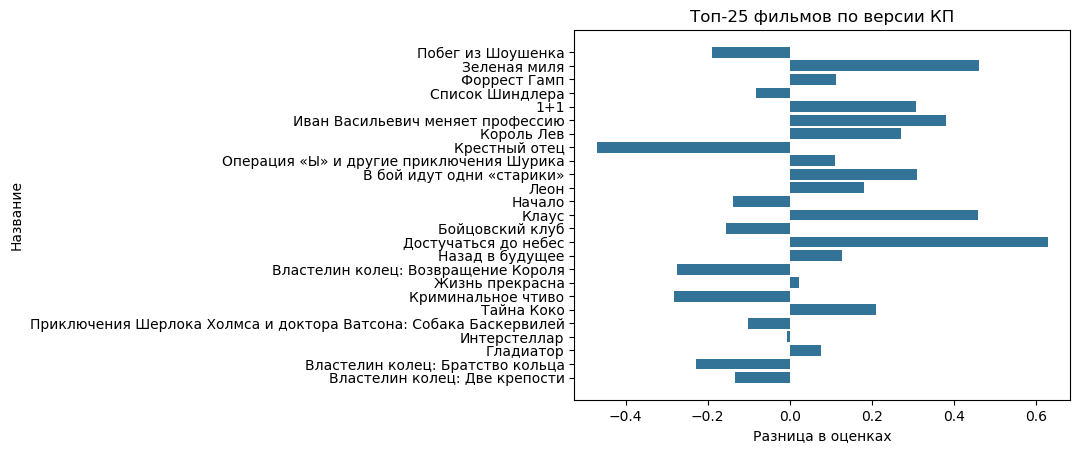

In [64]:
df_kp_rate = df.sort_values(by='kinopoisk_rate', ascending=False).head(25)


plt.rcdefaults()
fig, ax = plt.subplots()

plt.barh(df_kp_rate.film_name, df_kp_rate.difference, color='#347398')
ax.invert_yaxis()
plt.xlabel('Разница в оценках')
plt.ylabel('Название')
plt.title('Топ-25 фильмов по версии КП')
plt.show()

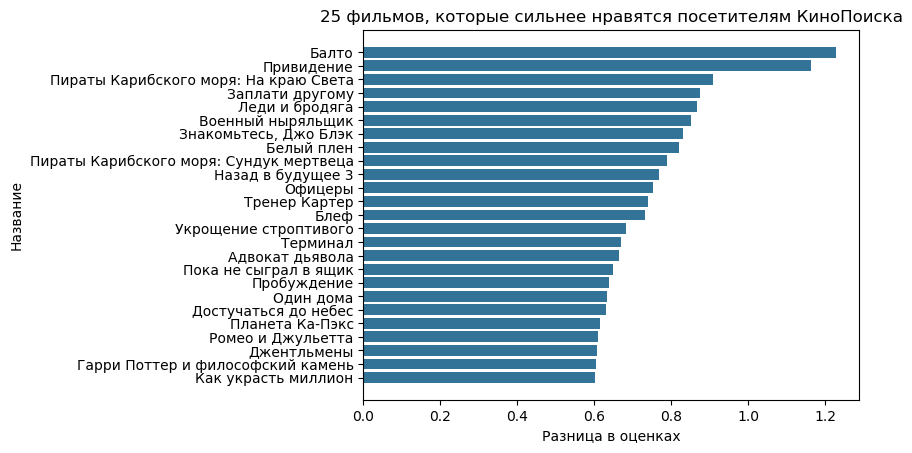

In [76]:
df_difference = df.sort_values(by='difference', ascending=False).head(25)


plt.rcdefaults()
fig, ax = plt.subplots()

plt.barh(df_differance.film_name, df_differance.difference, color='#347398')
ax.invert_yaxis()
plt.xlabel('Разница в оценках')
plt.ylabel('Название')
plt.title('25 фильмов, которые сильнее нравятся посетителям КиноПоиска')
plt.show()

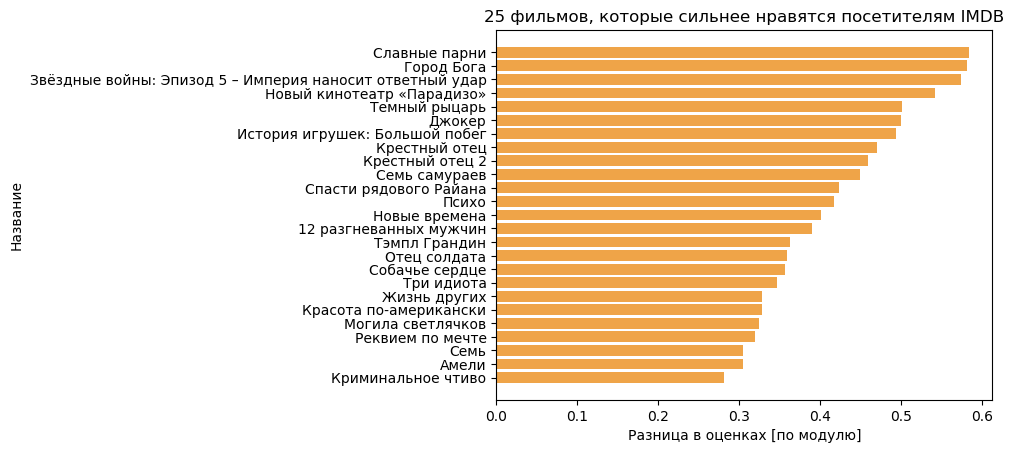

In [79]:
df_differance = df.sort_values(by='difference', ascending=False).tail(25)

plt.rcdefaults()
fig, ax = plt.subplots()

plt.barh(df_differance.film_name, df_differance.difference * -1, color='#EFA448')
#ax.invert_yaxis()
plt.xlabel('Разница в оценках [по модулю]')
plt.ylabel('Название')
plt.title('25 фильмов, которые сильнее нравятся посетителям IMDB')

plt.show()

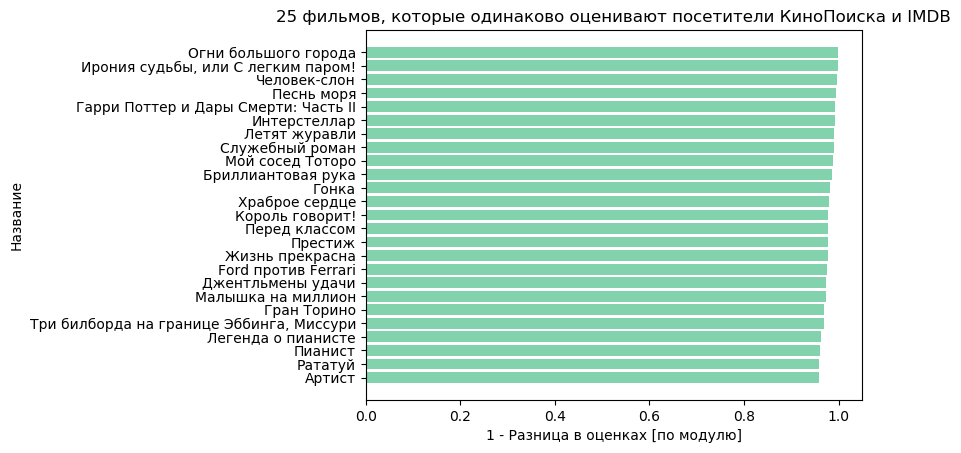

In [134]:
import math

def take_module(row):
    return math.fabs(row)

df_difference_module = df

df_difference_module['diff_mod'] = df_difference_module.difference.apply(take_module)

df_difference = df_difference_module.sort_values(by='diff_mod', ascending=True).head(25)

plt.rcdefaults()
fig, ax = plt.subplots()

plt.barh(df_difference.film_name, 1 - df_difference.diff_mod, color='#81D2AD')
ax.invert_yaxis()
plt.xlabel('1 - Разница в оценках [по модулю]')
plt.ylabel('Название')
plt.title('25 фильмов, которые одинаково оценивают посетители КиноПоиска и IMDB')

plt.show()

Бросается в глаза большая любовь российских зрителей к "Пиратам". Третий фильм серии также посетителями КиноПоиска оценивается выше.

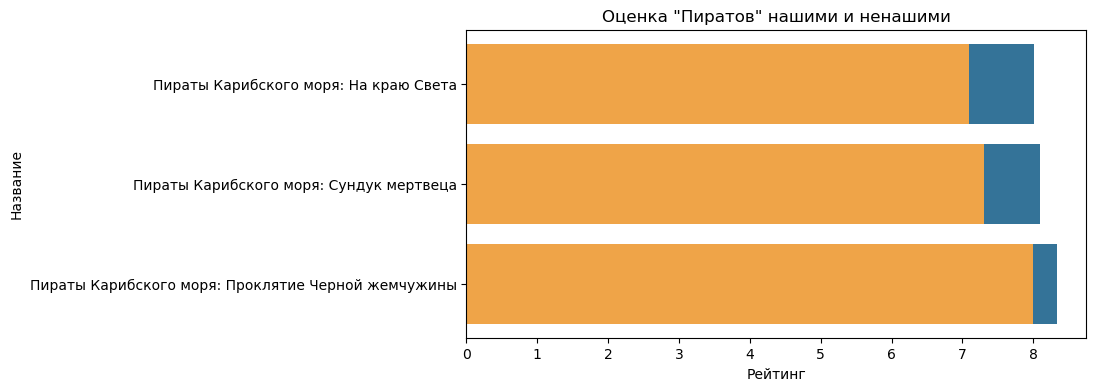

In [73]:
df_pirate = df[ df.original_name.str.contains('Pirate', case=True) ]

plt.rcParams['figure.figsize']=(8,4)

plt.barh(df_pirate.film_name, df_pirate.kinopoisk_rate, color='#347398')

ax.invert_yaxis()
plt.xlabel('Рейтинг')
plt.ylabel('Название')
plt.title('Оценка "Пиратов" нашими и ненашими')

plt.barh(df_pirate.film_name, df_pirate.imdb_rate, color='#EFA448')
ax.invert_yaxis()
    
#plt.legend(['КиноПоиск', 'IMDB'], loc = 'upper left')

plt.show()

In [137]:
df_difference_module.shape

(250, 7)

In [142]:
# самые "неоднозначные" режиссеры

df_difference_module.groupby('film_director').agg(
     {'film_director': 'count',
      'film_name': 'count',
      'diff_mod': 'mean'}
     ).sort_values(['film_name', 'diff_mod'], ascending=[False, False]).head(15)

,film_director,film_name,diff_mod
film_director,,,
Игорь Масленников,7,7,0.105429
Роберт Земекис,5,5,0.389200
Стивен Спилберг,5,5,0.344600
Дэвид Финчер,5,5,0.263400
Питер Джексон,5,5,0.213600
Кристофер Нолан,5,5,0.186400
Чарльз Чаплин,5,5,0.158000
Леонид Гайдай,5,5,0.124000
Гай Ричи,4,4,0.414750


Не считая Вербинского с "Пиратами" (которых на "КП" любят больше, чем "Назад в будущее"), наибольшие разногласия по фильмам Гая Ричи.

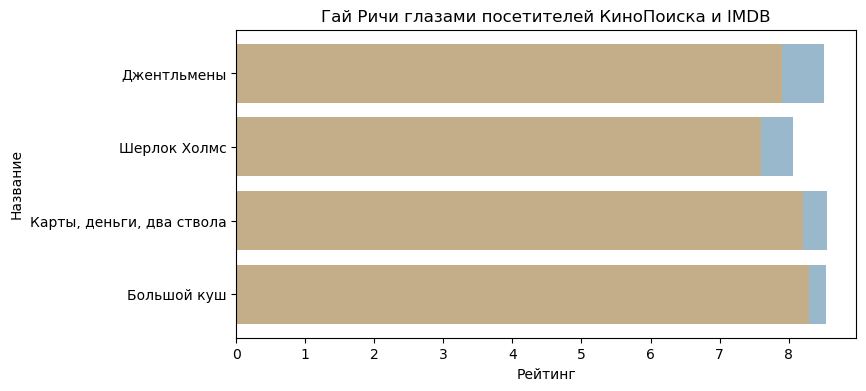

In [150]:
df_film_director = df[ df.film_director.str.contains('Гай Ричи', case=True) ]

plt.rcParams['figure.figsize']=(8,4)

plt.barh(df_film_director.film_name, df_film_director.kinopoisk_rate, color='#347398', alpha=0.5)

ax.invert_yaxis()
plt.xlabel('Рейтинг')
plt.ylabel('Название')
plt.title('Гай Ричи глазами посетителей КиноПоиска и IMDB')

plt.barh(df_film_director.film_name, df_film_director.imdb_rate, color='#EFA448', alpha=0.5)
ax.invert_yaxis()
    
#plt.legend(['КиноПоиск', 'IMDB'], loc = 'upper left')

plt.show()

### Русские фильмы: ###

Интересно посмотреть на разницу в оценках русских фильмов на КиноПоиске и IMDB.

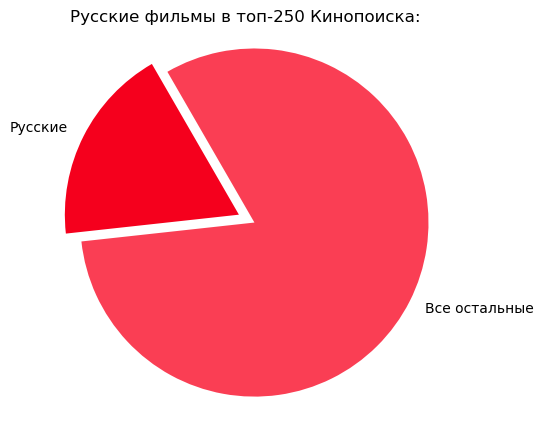

In [145]:
rus_films = len(df.original_name[df.original_name == ''])
others = len(df.original_name[df.original_name != ''])

plt.rcParams['figure.figsize']=(5,5)

labels = 'Русские', 'Все остальные' 
sizes = [rus_films, others]
explode = (0, 0.1)
colors = ['#F5001D', '#FA3E54']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, startangle=120, colors=colors)
ax1.axis('equal')
plt.title('Русские фильмы в топ-250 Кинопоиска:')

plt.show()

In [146]:
df_rus = df[ df.original_name == '']
df_rus.shape

(46, 7)

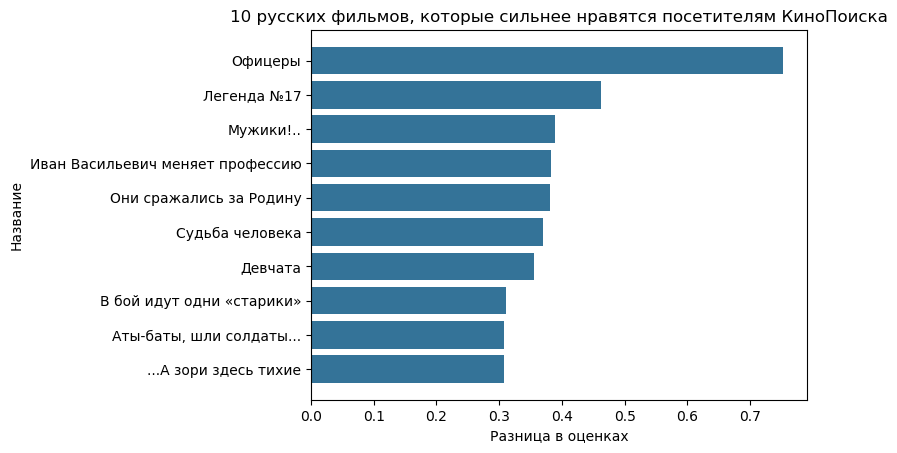

In [147]:
df_rus_differance = df_rus.sort_values(by='difference', ascending=False).head(10)


plt.rcdefaults()
fig, ax = plt.subplots()

plt.barh(df_rus_differance.film_name, df_rus_differance.difference, color='#347398')
ax.invert_yaxis()
plt.xlabel('Разница в оценках')
plt.ylabel('Название')
plt.title('10 русских фильмов, которые сильнее нравятся посетителям КиноПоиска')

top_expense = df_kp_rate.head(10)

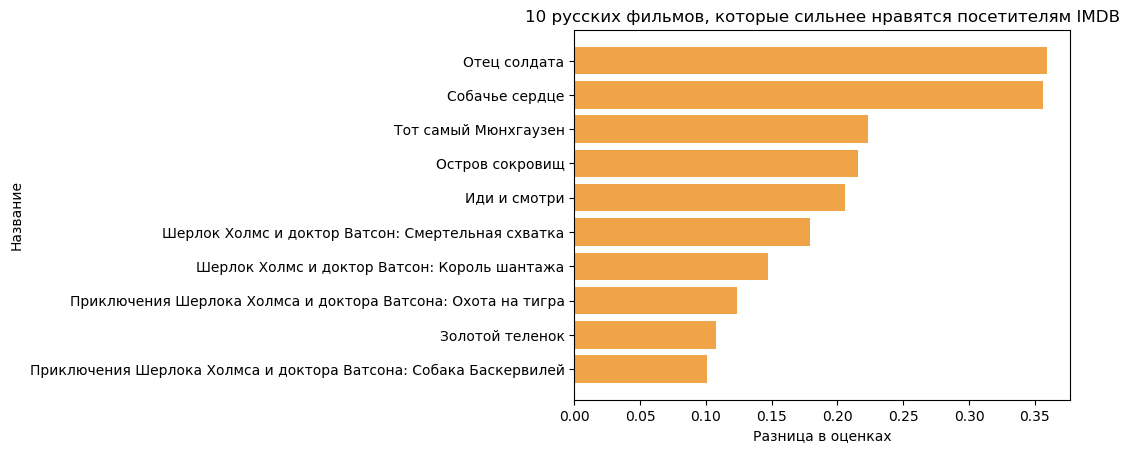

In [148]:
df_rus_differance = df_rus.sort_values(by='difference', ascending=False).tail(10)


plt.rcdefaults()
fig, ax = plt.subplots()

plt.barh(df_rus_differance.film_name, df_rus_differance.difference * -1, color='#EFA448')
#ax.invert_yaxis()
plt.xlabel('Разница в оценках')
plt.ylabel('Название')
plt.title('10 русских фильмов, которые сильнее нравятся посетителям IMDB')

top_expense = df_kp_rate.head(10)